In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pandas.plotting import register_matplotlib_converters
from pandas.tseries.offsets import MonthEnd

from shapely.ops import unary_union
from shapely.geometry import Polygon as shPolygon
from dateutil.relativedelta import relativedelta

from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

register_matplotlib_converters()

In [2]:
# Load shapefile of catchments
catchments = gp.read_file("../shape/sierra_catchments.shp")
# Find catchment csvs
data_dir = "../data/RS_catchdat/"
files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".csv")]

In [3]:
# Load csvs as dataframes 
dfdict = {x[-6:-4]:pd.read_csv(x) for x in files}

dfs = {}
for k,v in dfdict.items():
    if not k.isnumeric():
        idx = int(k[-1:])
        dfs[idx] = v
    else:
        idx = int(k)
        dfs[idx] = v

In [4]:
# Calc ensemble balance, write out min, max, mean 

In [5]:
dsdf_dict = {}
budyko_dict = {}
catch_ds = []

for k,v in dfs.items():
    catch = catchments.iloc[k]
    print(catch.catch_name, catch.area_km2)
    df = rs.col_to_dt(v)
    
    if 'Sres_outlet' in df.columns:
        outflow = df['Sres_outlet'].diff()
    else:
        outflow = df['qout_km3']
    
    # Remove first 4 years of data - no MODIS ET 
    adf = df[48:-8]
    
    # Compute an ensemble estimate for dS using MODIS ET, SSEBop ET, LRM SWE, Daymet SWE 
    adf.loc[:, ('ds1')] = adf['p_prism'] - adf['aet_modis'] - adf['swe_lrm'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    adf.loc[:, ('ds2')] = adf['p_prism'] - adf['aet_modis'] - adf['dmet_swe'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    adf.loc[:, ('ds3')] = adf['p_prism'] - adf['aet_ssebop'] - adf['swe_lrm'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    adf.loc[:, ('ds4')] = adf['p_prism'] - adf['aet_ssebop'] - adf['dmet_swe'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    
    # Since we computed differentials (.diff()), drop the first row
    adf = adf[1:]
    
    # Difference from 5 year baseline 
    ds1 = np.cumsum(adf['ds1'] - np.mean(adf['ds1'][:60]))
    ds2 = np.cumsum(adf['ds2'] - np.mean(adf['ds2'][:60]))
    ds3 = np.cumsum(adf['ds3'] - np.mean(adf['ds3'][:60]))
    ds4 = np.cumsum(adf['ds4'] - np.mean(adf['ds4'][:60]))
    
    # Get upper and lower bounds 
    dsdf = rs.col_to_dt(pd.DataFrame([ds1.index, 
                                      np.nanmin([ds1,ds2,ds3,ds4], axis = 0).astype(float), 
                                      np.nanmean([ds1,ds2,ds3,ds4], axis = 0).astype(float), 
                                      np.nanmax([ds1,ds2,ds3,ds4], axis = 0).astype(float)]).T)

    # Rename out cols 
    dsdf.columns = ['ds_min', 'ds_mean', 'ds_max']
    
    # Append to out dict 
    dsdf_dict[catch.catch_name] = dsdf
    
    # Budyko analysis
    p_aet = adf['aet_modis'].values.mean() / adf['p_prism'].values.mean()
    p_pet = adf['pet_modis'].values.mean() / adf['p_prism'].values.mean() 

#     print(p_aet,p_pet)
    
    budyko_dict[catch.catch_name] = [p_aet, p_pet]
    
    # Get the total change in storage for each wshed, and write to shapefile
    catch['ds_sum'] = round(dsdf['ds_mean'].iloc[-1],3)
    catch_ds.append(catch)
    
    # Plot ds for each wshed 
#     plt.plot(dsdf['ds_mean'], color = 'black',  linewidth=2, label = 'ds mean')
#     plt.fill_between(dsdf.index, dsdf['ds_min'].astype(float), dsdf['ds_max'].astype(float), color = 'gray', alpha = 0.7, label = 'ds range')
    
#     plt.show()


SACRAMENTO R 24146.043299999998
TULE R 1182.0492
MERCED R 3215.7486


/anaconda3/envs/pysheds/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/pysheds/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
<ipython-input-5-8b03e1284757>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

CALAVERAS R 1126.71
STANISLAUS R 2801.79
KINGS R 4702.4793
MOKELUMNE R 1771.0973999999999
FEATHER R 11426.2893
TUOLUMNE R 4722.405299999999
KAWEAH R 1954.9593
COSUMNES 1672.7633999999998
BEAR R 887.0472
SAN JOAQUIN R 5003.086499999999
KERN R 6221.0511
YUBA R 3495.3687
AMERICAN R 5838.2532


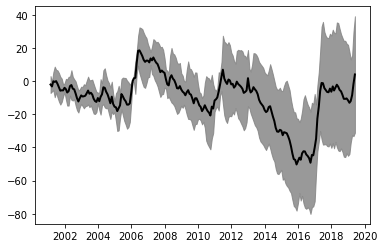

In [6]:
# Calc/Plot the cumulative sum for the whole Sierra 
net_ds = np.sum([v['ds_mean'].values for k,v in dsdf_dict.items()], axis = 0)
net_ds_max = np.sum([v['ds_max'].values for k,v in dsdf_dict.items()], axis = 0)
net_ds_min = np.sum([v['ds_min'].values for k,v in dsdf_dict.items()], axis = 0)

plt.plot(dsdf_dict["SACRAMENTO R"].index, net_ds, color = 'black', linewidth = 2)
plt.fill_between(dsdf_dict["SACRAMENTO R"].index, net_ds_min.astype(float),net_ds_max.astype(float), color = 'gray', alpha = 0.8)
plt.show()

# Append the sum to the out dict 
sndf = pd.DataFrame([net_ds,net_ds_max,net_ds_min]).T
sndf.columns = ['ds_mean', 'ds_max', 'ds_min']
sndf.index = dsdf_dict["SACRAMENTO R"].index
dsdf_dict['SIERRA NEVADA'] = sndf

# Concatenate the ΔS sum for each watershed we calculated in the last loop to a single gdf 
ds_catches = pd.DataFrame(pd.concat(catch_ds, axis = 1)).T

In [7]:
# Make a basemap plot with labels 

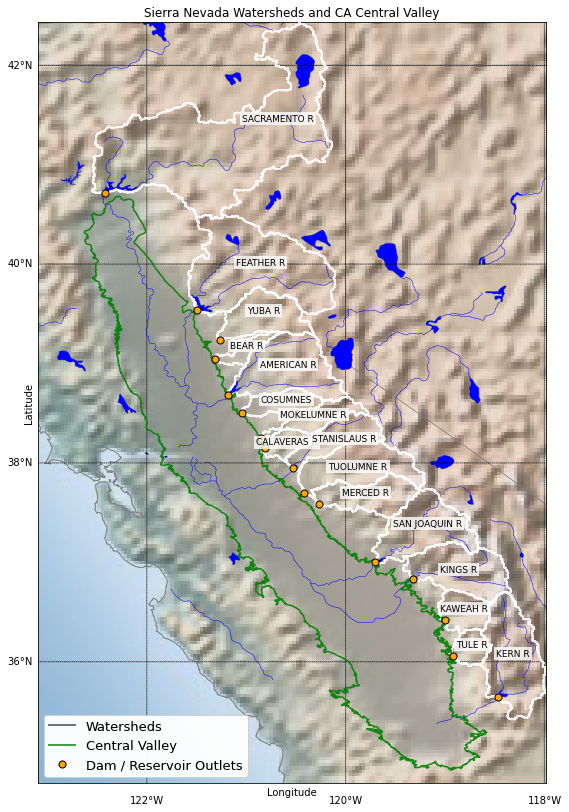

In [8]:
def draw_polys(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True, zorder = 3):
    
    '''
    Turns a geopandas gdf of multipolygons into matplotlib polygon patches for friendly plotting with basemap. 
    '''
    
    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill, zorder = zorder)
        plt.gca().add_patch(poly)

    return


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True, zorder = 4):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 50
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor, zorder = zorder)


# Load outlets shapefile
outlets = gp.read_file('../shape/outlets.shp')

# Load cv shapefile
cv = gp.read_file('../shape/cv.shp')

# Get the bbox using rasterio 
src = rio.open("../rasters/flowacc_clip.tif")

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(22,14))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)
draw_points(outlets,m, alpha = 1,  color= 'orange', edgecolor = 'black')

# Get some coords for shed labels
c = catchments.copy()
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

# Label the sheds
for idx, row in c.iterrows():
    ax1.text(row.coords[0], row.coords[1], s=row['catch_name'], horizontalalignment='center', size = 9,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# Titles and albels 
ax1.set_title("Sierra Nevada Watersheds and CA Central Valley")
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")

# Make the legend (lower left of map)
custom_lines = [Line2D([0], [0], color='black',markeredgecolor = 'black', alpha = 0.5, lw=2),
                Line2D([0], [0], color='green',markeredgecolor = 'black', alpha = 0.7, lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", "Central Valley",'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

plt.show()

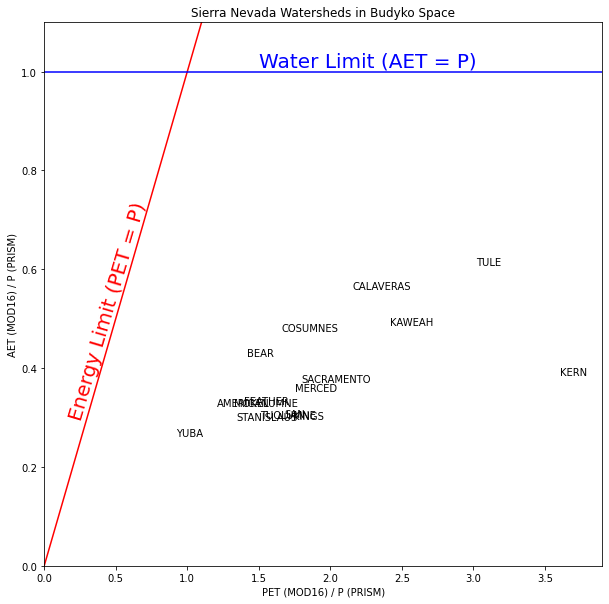

In [9]:
# Budyko plot
plt.figure(figsize = (10,10))

for k,v in budyko_dict.items():
    
    basinstr = k.split()[0]
    
    plt.scatter(v[1],v[0],alpha = 0)
    plt.text(v[1], v[0], basinstr, fontsize = 10)
    
    
plt.plot([-10,10],[-10,10],  color='r', linestyle='-', label = 'energy limit')
plt.axhline(y=1, color='blue', linestyle='-', label = 'water limit')

plt.text(1.5,1.01, 'Water Limit (AET = P)', color = 'blue', size = 20)
plt.text(0.16,0.3, 'Energy Limit (PET = P)', color = 'red', size = 20, rotation = np.degrees(np.pi/2.45))

plt.ylabel("AET (MOD16) / P (PRISM)")
plt.xlabel("PET (MOD16) / P (PRISM)")
# plt.xscale('log')
# plt.yscale('log')

plt.ylim([0,1.1])
plt.xlim([0,3.9])

plt.title("Sierra Nevada Watersheds in Budyko Space")
plt.show()

In [ ]:
# Load outlets shapefile
outlets = gp.read_file('../shape/outlets.shp')

# Load cv shapefile
cv = gp.read_file('../shape/cv.shp')

# Get the bbox using rasterio 
src = rio.open("../rasters/flowacc_clip.tif")

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup the figure
plt.figure(figsize=(18, 11))
G = gridspec.GridSpec(5, 2)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0:1])

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_polys(c, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)
draw_points(outlets,m, alpha = 1,  color= 'orange', edgecolor = 'black')

# Label the sheds
for idx, row in c.iterrows():
    ax1.text(row.coords[0], row.coords[1], s=row['catch_name'].split()[0][:3], horizontalalignment='center', size = 11,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# Titles and labels 
ax1.set_title("Sierra Nevada Watersheds and CA Central Valley")
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black',markeredgecolor = 'black', alpha = 0.5, lw=2),
                Line2D([0], [0], color='green',markeredgecolor = 'black', alpha = 0.7, lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", "Central Valley",'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

# Add legends
ax1.add_artist(leg1)

# Plot the Budyko plot
ax2 = plt.subplot(G[:, 1:2])

for k,v in budyko_dict.items():
    
    basinstr = k.split()[0]
    
    ax2.scatter(v[1],v[0],alpha = 0)
    ax2.text(v[1], v[0], basinstr[:3], fontsize = 10)
    
    
ax2.plot([-10,10],[-10,10],  color='r', linestyle='-', label = 'energy limit')
ax2.axhline(y=1, color='blue', linestyle='-', label = 'water limit')

ax2.text(1.5,1.01, 'Water Limit (AET = P)', color = 'blue', size = 20)
ax2.text(0.13,0.3, 'Energy Limit (PET = P)', color = 'red', size = 20, rotation = np.degrees(np.pi/2.28))

ax2.set_ylabel("AET (MOD16) / P (PRISM)")
ax2.set_xlabel("PET (MOD16) / P (PRISM)")

ax2.set_ylim([0,1.1])
ax2.set_xlim([0,3.9])

ax2.set_title("Budyko Plot of CVWS basins")

G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

plt.show()

In [ ]:
# TODO: kmeans clustering on budyko plot with K = 3? 

In [ ]:
# Make a plot of ΔS for certain basins 

In [ ]:
# Concatenate the ΔS sum for each watershed we calculated in the first loop to a single gdf 
ds_catches = gp.GeoDataFrame(pd.DataFrame(pd.concat(catch_ds, axis = 1)).T)

In [ ]:
plot_list = ['SIERRA','SAC','FEA', "AMER", "TUO", "SAN", "KAW", "KER"]
colorlist = ['purple','green','orange','pink','blue','gray','red','brown']

In [ ]:
# Load outlets shapefile
outlets = gp.read_file('../shape/outlets.shp')

# Load cv shapefile
cv = gp.read_file('../shape/cv.shp')

# Get the bbox using rasterio 
src = rio.open("../rasters/flowacc_clip.tif")

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup the figure
plt.figure(figsize=(18, 11))
G = gridspec.GridSpec(8, 2)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0:1])

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Setup the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
mappable = plt.cm.ScalarMappable(cmap = 'RdBu')
vmin = ds_catches['ds_sum'].min()
vmax = ds_catches['ds_sum'].max()

# Plot catchments, color by Δs
ds_catches.plot(ax=ax1,column = 'ds_sum',alpha = 0.5, edgecolor='black',cmap = 'RdBu',legend = False)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax=cax,)

# Plot CV and outlets 
cv.plot(ax=ax1,alpha = 0.9, facecolor="none", edgecolor = 'green', lw = 1.5)
draw_points(outlets,m, alpha = 1,  color= 'orange', edgecolor = 'black')

# Label the sheds
for idx, row in c.iterrows():
    ax1.text(row.coords[0], row.coords[1], s=row['catch_name'].split()[0][:3], horizontalalignment='center', size = 11,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# Titles and labels 
ax1.set_title('Cumulative $km^3 ΔS_{gw}$ (2001 - 2019) for Sierra Nevada Watersheds')
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")

# Make the second legend (lower left of map)
custom_lines = [Line2D([0], [0], color='black',markeredgecolor = 'black', alpha = 0.5, lw=2),
                Line2D([0], [0], color='green',markeredgecolor = 'black', alpha = 0.7, lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", "Central Valley",'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

# Plot the time series for the selected sheds 
plot_list = ['SIERRA NEVADA','SAC','FEA', "AMER", "TUO", "SAN", "KAW", "KER"]

for idx,i in enumerate(plot_list):
    
    # Get catchment area, abbreviation, and name 
    cname = [x for x in catchments.catch_name if i in x]
    if len(cname) ==0:
        area = round(catchments['area_km2'].sum(),1)
        cname = "Entire " + i
        abbv = "SNV"
    else:
        area = round(catchments[catchments['catch_name'] == cname[0]].area_km2.values[0],1)
        cname = " ".join(cname)
        abbv = cname.split()[0][:3]
        
    # Setup the subplot 
    ax = plt.subplot(G[idx:idx+1, 1:])
    df = [v for k,v in dsdf_dict.items() if i in k][0]
    
    # Plot the ΔS
    ax.plot(df['ds_mean'])
    ax.set_xlim(df['ds_mean'].dropna().index[0],df['ds_mean'].dropna().index[-1])
    ax.fill_between(df.index,df['ds_min'].astype(float),df['ds_max'].astype(float), alpha = 0.3)
    ax.set_title(cname + " (" +abbv+ ") "+ '$ΔS_{gw}$  $(km^3)$; Area = ' + str(area) + " $km^2$")

    if not idx == len(plot_list)-1:
        ax.get_xaxis().set_visible(False)

G.update(wspace=0.1, hspace=0.4) # set the spacing between axes. 

plt.tight_layout()
plt.show()

In [ ]:
# Load outlets shapefile
outlets = gp.read_file('../shape/outlets.shp')

# Load cv shapefile
cv = gp.read_file('../shape/cv.shp')

# Get the bbox using rasterio 
src = rio.open("../rasters/flowacc_clip.tif")

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup the figure
plt.figure(figsize=(18, 11))
G = gridspec.GridSpec(5, 2)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0:1])

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Setup the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
mappable = plt.cm.ScalarMappable(cmap = 'RdBu')
vmin = ds_catches['ds_sum'].min()
vmax = ds_catches['ds_sum'].max()

# Plot catchments, color by Δs
ds_catches.plot(ax=ax1,column = 'ds_sum',alpha = 0.5, edgecolor='black',cmap = 'RdBu',legend = False)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax=cax,)

# Plot CV and outlets 
cv.plot(ax=ax1,alpha = 0.9, facecolor="none", edgecolor = 'green', lw = 1.5)
draw_points(outlets,m, alpha = 1,  color= 'orange', edgecolor = 'black')

# Label the sheds
for idx, row in c.iterrows():
    ax1.text(row.coords[0], row.coords[1], s=row['catch_name'].split()[0][:3], horizontalalignment='center', size = 11,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# Titles and labels 
ax1.set_title('Cumulative $ΔS_{gw}$ (2001 - 2019) for Sierra Nevada Watersheds')
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")

# Make the second legend (lower left of map)
custom_lines = [Line2D([0], [0], color='black',markeredgecolor = 'black', alpha = 0.5, lw=2),
                Line2D([0], [0], color='green',markeredgecolor = 'black', alpha = 0.7, lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", "Central Valley",'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

In [ ]:
# Make animation

# Setup fig 
f, ax = plt.subplots(figsize=(12,4))

# get bbox of swe data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Select the first fig on left 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])

# Initialize the basemap
m = Basemap(ax = ax0,projection='merc', ellps='WGS84',resolution='i', 
            llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat) # CVWS bbox for basemap

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Plot array 
im = m.imshow(np.flipud(cvws_swe[:,:,0]), cmap='gist_ncar', vmin = 0, vmax = np.nanmax(mean_swe))

# Set location of the colorbar
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax)

######## Time Series Plot
ax1 = plt.subplot(gs[1])
line, = ax1.plot(dt_idx,swesums,color='k')
ax1.set_ylabel("SWE $(km^3)$")

###### Animation Functions
def animate(frame):
    im.set_array(np.array(np.flipud(cvws_swe[:,:,frame]))) 
    ax0.set_title("UCB LRM SWE (m) " + str(dt_idx[frame])[:-12])
    line.set_data(dt_idx[:frame],swesums[:frame])
    ax1.set_title("total SWE {} = {} $km^3$ ".format(str(dt_idx[frame])[:-12],str(round(np.nansum(swesums[frame]),2))))

# Finally, use the animation module to create the animation.
ani = animation.FuncAnimation(
    f,               # figure
    animate,         # name of the function above
    frames= cvws_swe.shape[2],       # Could also be iterable or list
    interval=250, # ms between frames
    repeat = True
)

HTML(ani.to_jshtml())